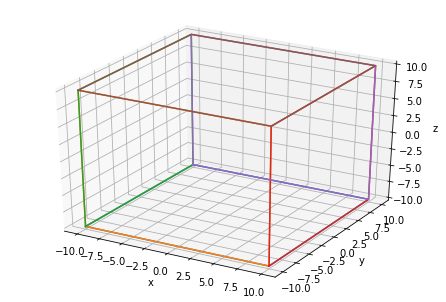

In [1]:
import numpy as np
import cv2

# 別にpointを直接使う必要はないはず？
# この階層のpointを便宜上使うってことにすればいい。
# もっと細かくしたいときは上の階層をこのpointsを使って定義してね
_cube_faces = np.array([[0, 1, 2, 3],
                       [0, 1, 5, 4],
                       [0, 3, 7, 4],
                       [1, 2, 6, 5],
                       [3, 2, 6, 7],
                       [4, 5, 6, 7]])

# face must be 巡回
def toTriangle(faces):
    ret = []
    for face in faces:
        if len(face) == 3:
            ret.append(face)
        elif len(face) == 4:
            ret.append(face[[0,1,2]])
            ret.append(face[[2,3,0]])
        else:
            assert False, NotImplementedError
    ret = np.array(ret)
    return ret

cube_faces = toTriangle(_cube_faces)
cube_colors = np.array([[np.random.randint(8)*30, np.random.randint(8)*30, np.random.randint(8)*30] for _ in range(12)])

cube_points = np.array([[-10, -10, -10],
                        [10, -10, -10],
                        [10, 10, -10],
                        [-10, 10, -10],
                        [-10, -10, 10],
                        [10, -10, 10],
                        [10, 10, 10],
                        [-10, 10, 10],], dtype=np.float32)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3Dでプロット
fig = plt.figure()
ax = Axes3D(fig)

for f in cube_faces:
    points = cube_points[f.tolist()+f[:1].tolist()]
    ax.plot(points[:,0], points[:,1], points[:,2])

# 軸ラベル
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# 表示
plt.show()

In [7]:
import numpy as np
import cv2

# 別にpointを直接使う必要はないはず？
# この階層のpointを便宜上使うってことにすればいい。
# もっと細かくしたいときは上の階層をこのpointsを使って定義してね
cube_faces = np.array([[0, 1, 2, 3],
                       [0, 1, 5, 4],
                       [0, 3, 7, 4],
                       [1, 2, 6, 5],
                       [3, 2, 6, 7],
                       [4, 5, 6, 7]])

# face must be 巡回
# def toTriangle(faces):
#     ret = []
#     for face in faces:
#         if len(face) == 3:
#             ret.append(face)
#         elif len(face) == 4:
#             ret.append(face[[0,1,2]])
#             ret.append(face[[2,3,0]])
#         else:
#             assert False, NotImplementedError
#     ret = np.array(ret)
#     return ret

# cube_faces = toTriangle(_cube_faces)
cube_colors = np.array([[np.random.randint(8)*30, np.random.randint(8)*30, np.random.randint(8)*30] for _ in range(12)])

cube_points = np.array([[-10, -10, -10],
                        [10, -10, -10],
                        [10, 10, -10],
                        [-10, 10, -10],
                        [-10, -10, 10],
                        [10, -10, 10],
                        [10, 10, 10],
                        [-10, 10, 10],], dtype=np.float32)



def rot(points, r):
    rx, ry, rz = np.deg2rad(r)
    rotx = np.array([
        [1., 0., 0.],
        [0., np.cos(rx), -np.sin(rx)],
        [0., np.sin(rx), np.cos(rx)],
    ])
    roty = np.array([
        [np.cos(ry), 0., -np.sin(ry)],
        [0., 1., 0.],
        [np.sin(ry), 0., np.cos(ry)],
    ])
    rotz = np.array([
        [np.cos(rz), -np.sin(rz), 0.],
        [np.sin(rz), np.cos(rz), 0.],
        [0., 0., 1.],
    ])
    return np.dot(rotz, np.dot(roty, np.dot(rotx, points.T))).T


class Pose():  # 構造体?
    def __init__(self, p=np.zeros(3), r=np.zeros(3)):
        self.p = p.astype(np.float32)  # x, y, z
        self.r = r.astype(np.float32)  # x, y, z

class Points():
    pass

class Faces():
    pass


class Entity():
    def __init__(self):
        self.children = []

    # def __init__(self, attrs):
    #     for k, v in attrs.items():
    #         setattr(self, k, v)

    def set_pose(self, pose):
        self.pose = pose

    def set_points(self, points):
        self.points = rot(points, self.pose.r)
    
    def set_faces(self, faces):
        self.faces = faces
    
    def set_colors(self, colors):
        self.colors = colors

    def update_hogehoge(self):
        pass

    def add_children(self, children):  # 一括で突っ込めるようにする。
        self.children.extend(children)


class Renderer():
    def __init__(self, world):
        self.world = world

    def render(self, r=np.zeros(3)):
        frames = []
        for child in self.world.children:  # 並列処理(multi processing)
            if hasattr(child, 'render'):
                frames.extend(child.render(r))  # N枚、[f,p,s]のリスト

        frames = sorted(frames, key=lambda x:x[1][1], reverse=True)  # pのy座標
        size = np.array([1000, 800, 3])
        frame = np.zeros(size, dtype=np.uint8)
        ### 奥の点にあるfaceからrenderする
        ### 変化があったとこからrenderしたい?
        ### 立体的なところでは、変化を見るべきだけど、renderするときは本質的じゃないのでそこまでしなくていい
        for f,p,s in frames:  # p[x,y,z], s[x,z,3]  # もうp[y]は要らない
            p = p[[0,2]]
            w, h = s[0], s[1]
            p += (size[:2] / 2.).astype(np.int)
            x, z = p[0] - int(w/2), p[1] - int(h/2)
            if w*h > 0:
                mask = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
                _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
                mask_inv = cv2.bitwise_not(mask)
                roi = frame[x:x+w, z:z+h]
                bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
                fg = cv2.bitwise_and(f,f,mask=mask)
                roi = cv2.add(bg, fg)

                frame[x:x+w, z:z+h] = roi

        w, h, _ = frame.shape
        cw, ch = int(w/2), int(h/2) # center
        cv2.line(frame, (0, cw), (h, cw), color=(255, 255, 255))
        cv2.line(frame, (ch, 0), (ch, w), color=(255, 255, 255))
        frame = np.transpose(frame, (1,0,2))[::-1]
        cv2.imshow("frame", frame)
        cv2.waitKey(1)
    
    def add_entities(self, entities):
        for entity in entities:
            self.PolygonRendered_Entity(entity)


# 多重継承は面倒なので、メンバ変数にする。
# Render_v1 field
class PolygonRendered_Entity():
    def __init__(self, entity):
        self.entity = entity
        self.entity.render = self.render

    # (f,p,s) (画像,中心座標,サイズ)を返す
    def render(self, r):
        _points = rot(self.entity.points + self.entity.pose.p, r)

        # TODO: バッチ処理する
        polygons = []
        for i, face in enumerate(self.entity.faces):  # 並列処理(multi processing)
            polygons.append(self.render_polygon(_points, face, i))
        return polygons

    def render_polygon(self, _points, face, i):  # グローバル座標p(四角形の中心)
        _points = _points[face]
        p = ((_points.max(0) + _points.min(0))/2.).astype(np.int)
        p[1] = _points.mean(0)[1].astype(np.int)
        _points = _points - _points.min(0)
        s = np.ceil(_points.max(0)).astype(np.int)
        s = np.insert(s[[0,2]], 2, [3])  # x,z
        f = np.zeros(s, dtype=np.uint8)
        cv2.fillConvexPoly(f, _points[:,[2,0]].astype(np.int), self.entity.colors[i].tolist())
        return f, p, s


world = Entity()
renderer = Renderer(world)

cubes = []
for i in range(30):
    cube_pose = Pose(np.array([np.random.randint(-200, 200),
                               np.random.randint(-200, 200),
                               np.random.randint(-200, 200)]),
                     np.array([np.random.randint(0, 360),
                               np.random.randint(0, 360),
                               np.random.randint(0, 360)]))
    cube_points = np.array([[-10, -10, -10],
                            [10, -10, -10],
                            [10, 10, -10],
                            [-10, 10, -10],
                            [-10, -10, 10],
                            [10, -10, 10],
                            [10, 10, 10],
                            [-10, 10, 10],
                           ], dtype=np.float32) * (np.random.random() + 1) * 1.5
    cube_colors = np.array([[np.random.randint(8)*30, np.random.randint(8)*30, np.random.randint(8)*30] for _ in range(12)])
    cube = Entity()
    cube.set_pose(pose=cube_pose)
    cube.set_points(points=cube_points)
    cube.set_faces(faces=cube_faces)
    cube.set_colors(colors=cube_colors)
    PolygonRendered_Entity(cube)
    cubes.append(cube)

world.add_children(cubes)
renderer.render(r=np.array([0.,0.,45]))

for t in range(900):
#     renderer.render(r=np.array([0,0,np.float32(t)]))
    renderer.render(r=np.array([np.float32(t),np.float32(t),np.float32(t)]))    